In [19]:
import os
import sys

if os.path.basename(os.getcwd()) == "analysis":
    os.chdir(os.path.dirname(os.getcwd()))
    sys.path.append(os.getcwd())

import torch
from lossless.component.core.arm_image import ImageARMParameter
from lossless.component.coolchic import (CoolChicEncoder,
                                         CoolChicEncoderParameter)
from lossless.configs.config import args
from lossless.util.image_loading import load_image_as_tensor
from lossless.util.parsecli import (change_n_out_synth,
                                    get_coolchic_param_from_args)
from lossless.util.command_line_args_loading import load_args
from typing import cast
from lossless.training.manager import ImageEncoderManager
from lossless.training.loss import loss_function

image_index = 0
use_image_arm = True
encoder_gain = 64

command_line_args = load_args(notebook_overrides = {
    "image_index": image_index,
    "encoder_gain": encoder_gain,
    "color_space": "YCoCg",
    "use_image_arm": use_image_arm,
    "multiarm_setup": "2x2",

})
im_path = args["input"][command_line_args.image_index]
im_tensor, colorspace_bitdepths = load_image_as_tensor(
    im_path, device="cuda:0", color_space=command_line_args.color_space
)

# ORIGINAL:
args["arm_image_params"] = ImageARMParameter(context_size=8, n_hidden_layers=2, hidden_layer_dim=6)
args["layers_synthesis_lossless"] = "24-1-1-linear-relu,X-1-1-linear-none,X-3-3-residual-relu,X-3-3-residual-none"
multi_arm_setup: tuple[int, int] = cast(
    tuple[int, int], tuple(map(int, command_line_args.multiarm_setup.split("x")))
)
image_encoder_manager = ImageEncoderManager(
    preset_name=args["preset"],
    colorspace_bitdepths=colorspace_bitdepths,
    multi_region_image_arm_setup=multi_arm_setup,
)

encoder_param = get_coolchic_param_from_args(
    args,
    "lossless",
    image_size=(im_tensor.shape[2], im_tensor.shape[3]),
    use_image_arm=command_line_args.use_image_arm,
    encoder_gain=command_line_args.encoder_gain,
    multi_region_image_arm_setup=command_line_args.multiarm_setup,
)
encoder_param.use_image_arm = use_image_arm
encoder_param.encoder_gain = encoder_gain
encoder_param.set_image_size((im_tensor.shape[2], im_tensor.shape[3]))
encoder_param.layers_synthesis = change_n_out_synth(
    encoder_param.layers_synthesis, 9 if args['use_color_regression'] else 6
)
coolchic = CoolChicEncoder(param=encoder_param)
coolchic.to_device("cuda:0")
coolchic.image_arm.params.multi_region_image_arm_specification.simple_grid_routing(
        image_encoder_manager.multi_region_image_arm_setup[0],
        image_encoder_manager.multi_region_image_arm_setup[1],
    )
coolchic.image_arm.reinitialize_image_arm_experts(
    num_experts=int(coolchic.image_arm.params.multi_region_image_arm_specification.num_experts.item()),
    pretrained_expert_index=0,
)


In [20]:
coolchic.load_from_disk("../logs_cluster/logs/full_runs/february/2026_02_19_kodak_two_by_two/trained_models/2026_02_19__16_51_35__trained_coolchic_kodak_kodim01_job_0_img_rate_3.294210433959961.pth")
rate_per_module, total_network_rate = coolchic.get_network_rate()
total_network_rate = 0.0345

with torch.no_grad():
    # Forward pass with no quantization noise
    predicted_prior = coolchic.forward(
        image=im_tensor,
        quantizer_noise_type="none",
        quantizer_type="hardround",
        AC_MAX_VAL=-1,
        flag_additional_outputs=False,
    )
    predicted_priors_rates = loss_function(
        predicted_prior,
        im_tensor,
        rate_mlp_bpd=total_network_rate,
        colorspace_bitdepths=colorspace_bitdepths,
    )

print(
    f"Final frame_encoder_manager state: {image_encoder_manager},\n"
    f"Rate per module: {rate_per_module},\n"
    f"Final results after quantization: {predicted_priors_rates}"
)


Final frame_encoder_manager state: ImageEncoderManager(colorspace_bitdepths=<lossless.util.color_transform.YCoCgBitdepths object at 0x79a70a1c92a0>, preset_name='fnlic', multi_region_image_arm_setup=(2, 2), start_lr=0.01, n_itr=142500, n_loops=1, preset=PresetFNLIC(preset_name='fnlic', warmup=Warmup(phases=[WarmupPhase(candidates=10, training_phase=TrainerPhase(lr=0.01, max_itr=1000, freq_valid=100, patience=100000, quantize_model=False, schedule_lr=False, softround_temperature=(0.3, 0.3), noise_parameter=(2.0, 2.0), quantizer_noise_type='kumaraswamy', quantizer_type='softround', optimized_module=['all'])), WarmupPhase(candidates=4, training_phase=TrainerPhase(lr=0.01, max_itr=1000, freq_valid=100, patience=100000, quantize_model=False, schedule_lr=False, softround_temperature=(0.3, 0.3), noise_parameter=(2.0, 2.0), quantizer_noise_type='kumaraswamy', quantizer_type='softround', optimized_module=['all']))]), training_phases=[TrainerPhase(lr=0.01, max_itr=140000, freq_valid=100, patienc

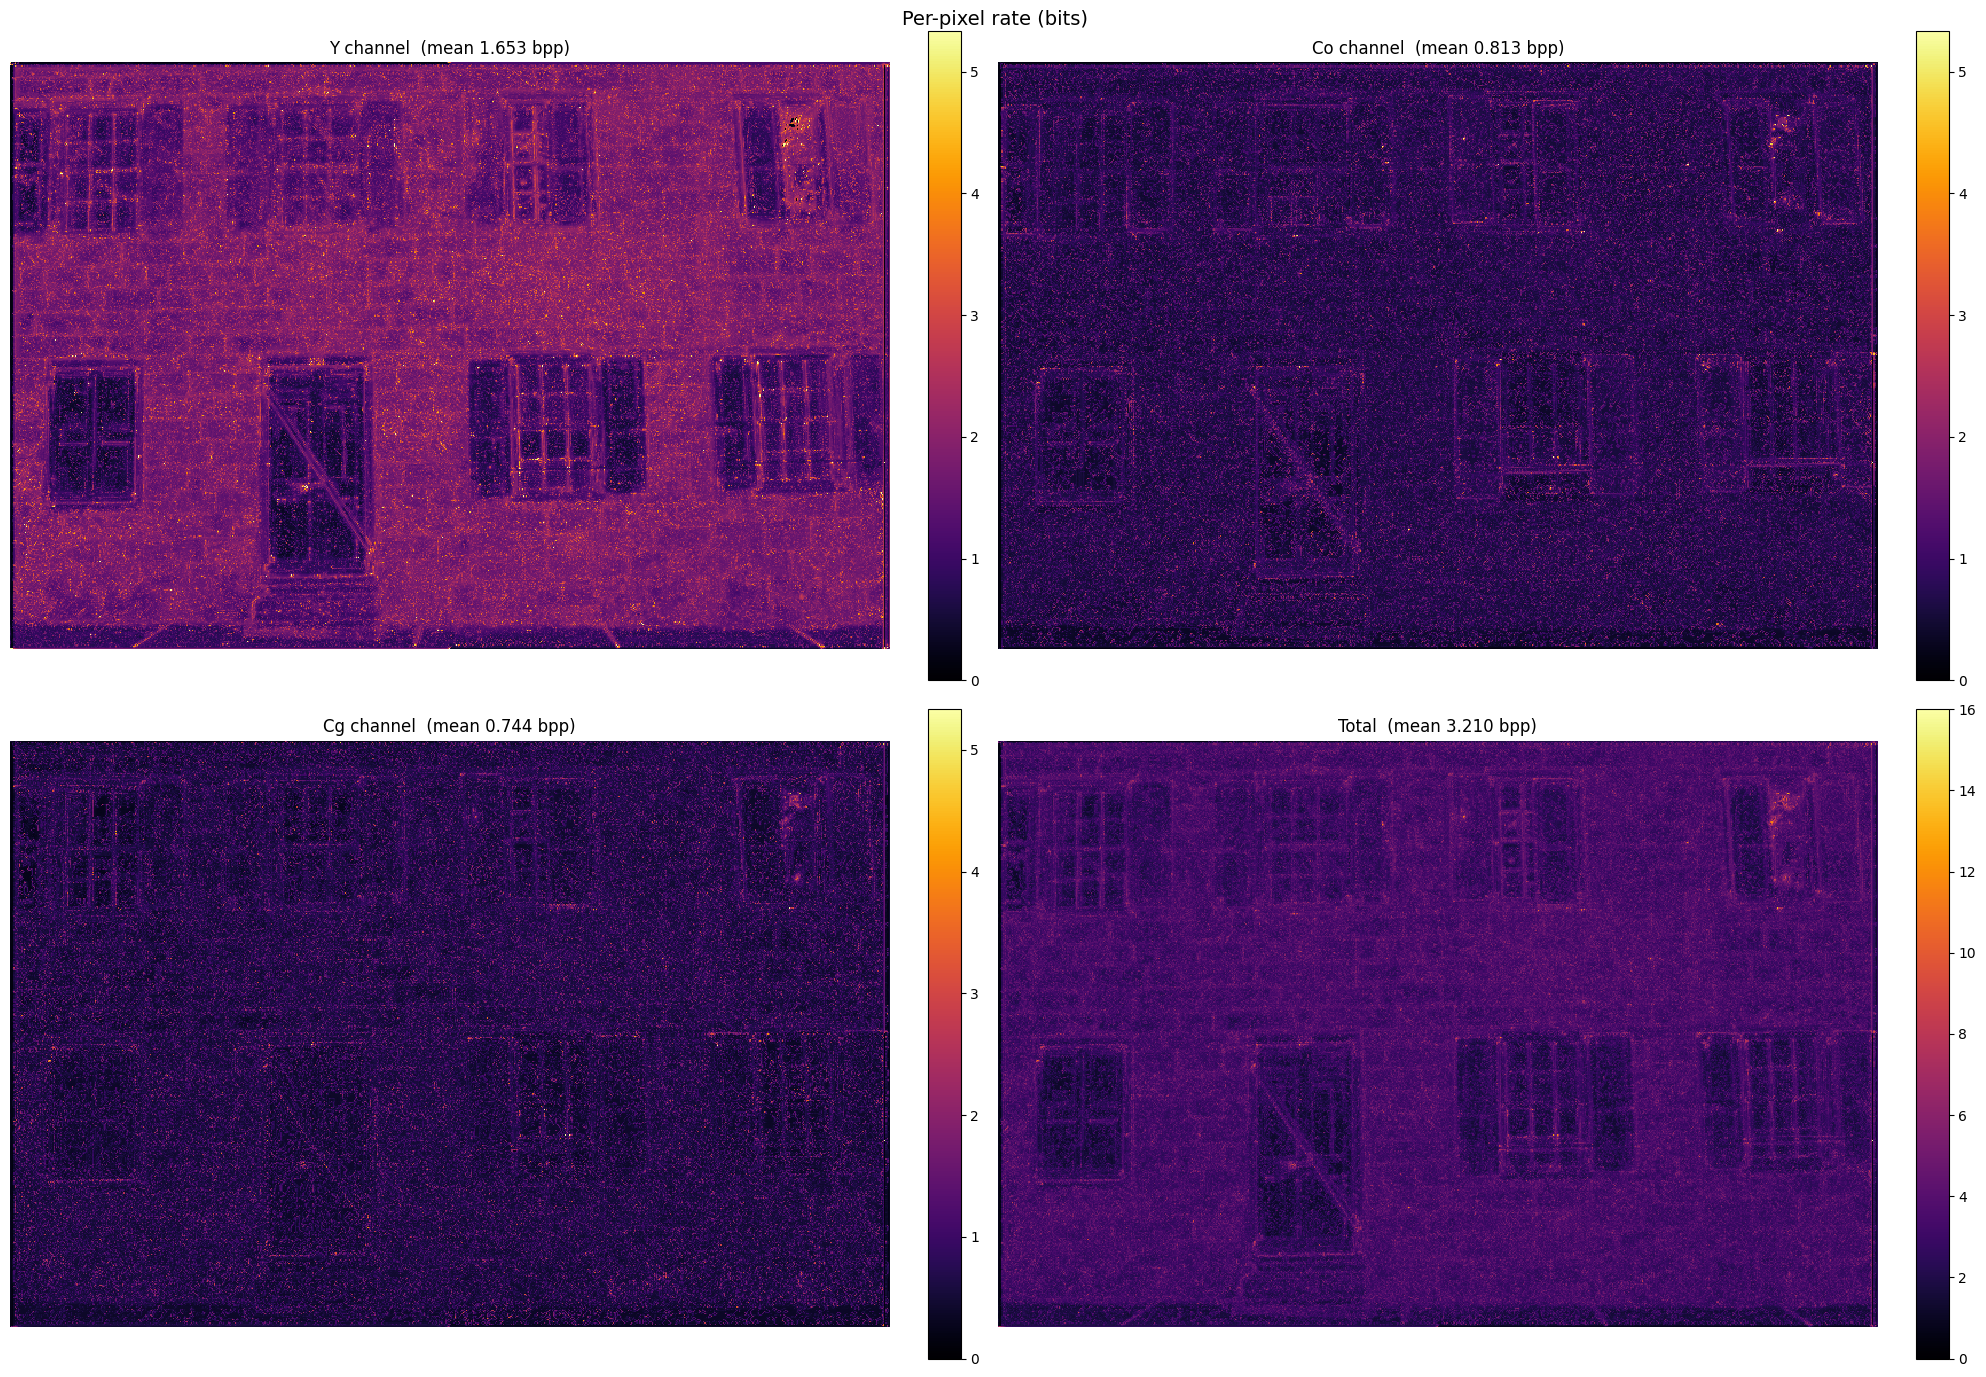

In [47]:
from lossless.util.distribution import weak_colorar_rate

img_rates = weak_colorar_rate(
    predicted_prior["mu"], predicted_prior["scale"], im_tensor, colorspace_bitdepths
)
import matplotlib.pyplot as plt

rates = img_rates[0].cpu()/3  # C H W
rates_threshold = 2.0
# rates[rates <= rates_threshold] = 0
# rates[:,:rates.shape[1]//2,:rates.shape[2]//2] = 0
channel_names = ["Y", "Co", "Cg"]
total_rate = rates.sum(dim=0)  # H W

fig, axes = plt.subplots(2, 2, figsize=(20, 14))
axes = axes.flatten()
vmin = 0

# Plot the three channels
for i, name in enumerate(channel_names):
    im = axes[i].imshow(rates[i], cmap="inferno", vmin=0, vmax=rates[i].max().item(), interpolation="nearest")
    axes[i].set_title(f"{name} channel  (mean {rates[i].mean():.3f} bpp)")
    axes[i].axis("off")
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

# Plot the total rate in the fourth subplot
im = axes[3].imshow(total_rate, cmap="inferno", vmin=0, vmax=total_rate.max().item(), interpolation="nearest")
axes[3].set_title(f"Total  (mean {total_rate.mean():.3f} bpp)")
axes[3].axis("off")
fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)

fig.suptitle("Per-pixel rate (bits)", fontsize=14)
fig.tight_layout()
plt.show()


In [22]:
# import numpy as np

# # get all of the float values of coolchic.image_arm.image_arm_models
# with torch.no_grad():
#     float_values = [
#         param.detach().clone() for param in coolchic.image_arm.image_arm_models.parameters()
#     ]
#     float_values = [float_value.cpu().numpy() for float_value in float_values]
#     two_dim_weights = [float_value for float_value in float_values if float_value.ndim == 2]
#     one_dim_weights = [float_value for float_value in float_values if float_value.ndim == 1]
#     assert len(two_dim_weights) + len(one_dim_weights) == len(float_values)

#     # # plot the one dim weights as a image
#     # canvas = np.ones((len(one_dim_weights), max(len(weight) for weight in one_dim_weights))) * -1

#     # for i, weight in enumerate(one_dim_weights):
#     #     canvas[i, : len(weight)] = weight

#     # fig, ax = plt.subplots(figsize=(20, 6))
#     # height, width = canvas.shape
#     # im = ax.imshow(canvas, cmap="coolwarm", vmin=-1, vmax=1, aspect="auto", interpolation="nearest")
#     # fig.colorbar(im, ax=ax)
#     # plt.show()

#     # canvas = np.zeros((192,32))
#     # row_index = 0
#     # for i, weight in enumerate(two_dim_weights):
#     #     # print(weight.shape)
#     #     canvas[row_index: row_index + weight.shape[0], : weight.shape[1]] = weight
#     #     row_index += weight.shape[0]

#     # fig, ax = plt.subplots(figsize=(20, 12))
#     # im = ax.imshow(canvas, cmap="inferno", aspect="auto", interpolation="nearest") # , vmin=0, vmax=1
#     # fig.colorbar(im, ax=ax)
#     # plt.show()


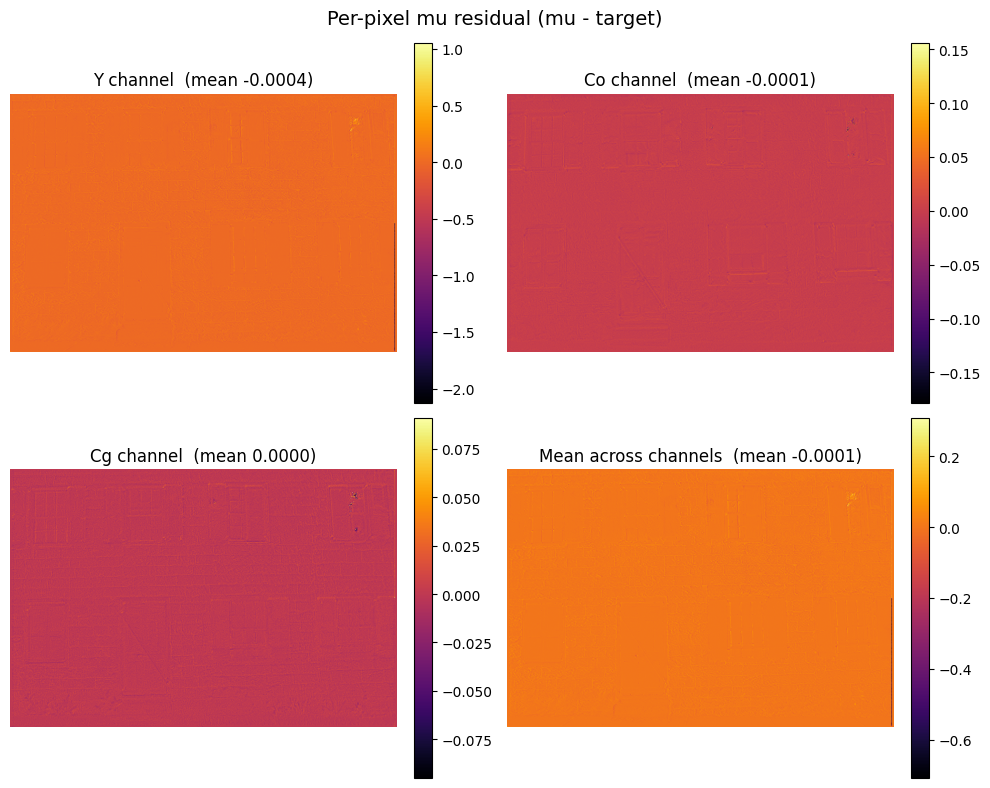

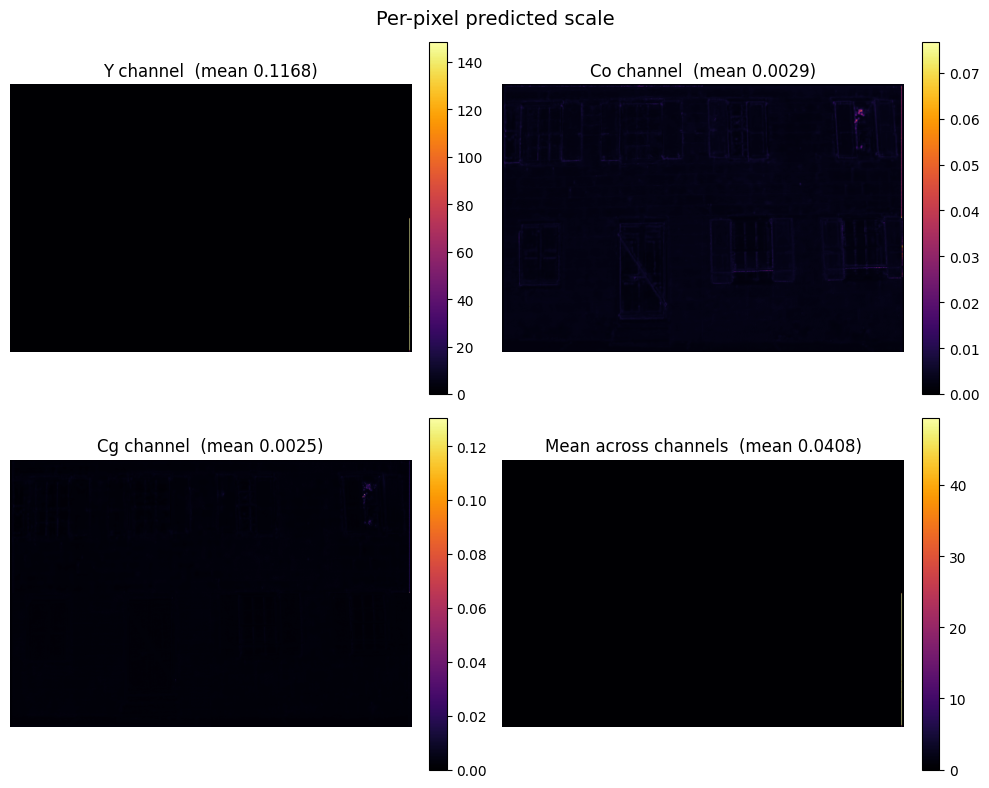

In [23]:
import matplotlib.pyplot as plt

mu = predicted_prior["mu"].detach().cpu()[0]  # C H W
im_target = im_tensor.detach().cpu()[0]  # C H W
channel_names = ["Y", "Co", "Cg"]

# --- mu residual (mu - target) ---
mu_residual = mu - im_target
total_residual = mu_residual.mean(dim=0)  # H W

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, name in enumerate(channel_names):
    im = axes[i].imshow(mu_residual[i], cmap="inferno", vmin=mu_residual[i].min().item(), vmax=mu_residual[i].max().item())
    axes[i].set_title(f"{name} channel  (mean {mu_residual[i].mean():.4f})")
    axes[i].axis("off")
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

im = axes[3].imshow(total_residual, cmap="inferno", vmin=total_residual.min().item(), vmax=total_residual.max().item())
axes[3].set_title(f"Mean across channels  (mean {total_residual.mean():.4f})")
axes[3].axis("off")
fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)

fig.suptitle("Per-pixel mu residual (mu - target)", fontsize=14)
fig.tight_layout()
plt.show()

# --- scale ---
scale = predicted_prior["scale"].detach().cpu()[0]  # C H W
total_scale = scale.mean(dim=0)  # H W

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for i, name in enumerate(channel_names):
    im = axes[i].imshow(scale[i], cmap="inferno", vmin=0, vmax=scale[i].max().item())
    axes[i].set_title(f"{name} channel  (mean {scale[i].mean():.4f})")
    axes[i].axis("off")
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

im = axes[3].imshow(total_scale, cmap="inferno", vmin=0, vmax=total_scale.max().item())
axes[3].set_title(f"Mean across channels  (mean {total_scale.mean():.4f})")
axes[3].axis("off")
fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)

fig.suptitle("Per-pixel predicted scale", fontsize=14)
fig.tight_layout()
plt.show()


In [24]:
from dataclasses import dataclass, field

@dataclass
class SimpleARMOutput():
    mu: torch.Tensor
    scale: torch.Tensor
    latent_bpd: torch.Tensor = field(default=torch.tensor(0.0))

    def __setitem__(self, key, item):
        self.__dict__[key] = item

    def __getitem__(self, key):
        return self.__dict__[key]

In [25]:
from torch import nn, Tensor
from lossless.component.core.arm import ArmLinear, _get_neighbor, _get_non_zero_pixel_ctx_index


class SimpleARMNetwork(torch.nn.Module):
    """Second-stage AR model that residually refines Cool-Chic's mu/scale.

    Causality contract (identical to ImageArm):
      - Spatial: only pixels in the causal 9x9 half-mask (above + left)
      - Cross-channel: when predicting channel c, only channels 0..c-1
        of the *current* pixel are visible.
    """

    MASK_SIZE = 9

    def __init__(
        self,
        num_channels: int = 3,
        context_size: int = 8,
        hidden_dim: int = 40,
        n_hidden_layers: int = 2,
        context_mu_scale: bool = True,
    ) -> None:
        super().__init__()
        self.num_channels = num_channels
        self.context_size = context_size
        self.hidden_dim = hidden_dim
        self.n_hidden_layers = n_hidden_layers
        self.context_mu_scale = context_mu_scale

        self.register_buffer(
            "non_zero_ctx_index",
            _get_non_zero_pixel_ctx_index(context_size),
            persistent=False,
        )

        self.channel_networks = nn.ModuleList()
        for c in range(num_channels):
            if self.context_mu_scale:
                in_dim = (
                    context_size * num_channels  # causal spatial context (all channels)
                    + num_channels * context_size  # Cool-Chic mu
                    + num_channels * context_size  # Cool-Chic scale
                    + c  # already-decoded channels 0..c-1 at current pixel
                )
            else:
                in_dim = (
                    context_size * num_channels  # causal spatial context (all channels)
                    + num_channels * 2
                    + c  # Cool-Chic mu
                )
            self.channel_networks.append(self._build_mlp(in_dim, output_dim=2))

    def _build_mlp(self, in_dim: int, output_dim: int) -> nn.Sequential:
        layers: list[nn.Module] = []
        layers.append(ArmLinear(in_dim, self.hidden_dim, residual=False))
        layers.append(nn.SiLU())
        for _ in range(self.n_hidden_layers - 1):
            layers.append(ArmLinear(self.hidden_dim, self.hidden_dim, residual=True))
            layers.append(nn.SiLU())
        layers.append(ArmLinear(self.hidden_dim, output_dim * 2, residual=False))
        return nn.Sequential(*layers)

    # ------------------------------------------------------------------
    # Input preparation (batch mode — full image at once during training)
    # ------------------------------------------------------------------
    def prepare_inputs(
        self,
        image: Tensor,
        mu: Tensor,
        scale: Tensor,
    ) -> list[Tensor]:
        """Build per-channel input tensors that respect causality.

        Args:
            image: [1, C, H, W] ground-truth pixels (training) or decoded-so-far
            mu:    [1, C, H, W] Cool-Chic predicted means
            scale: [1, C, H, W] Cool-Chic predicted scales

        Returns:
            List of C tensors, each [H*W, in_dim_for_channel_c]
        """
        C = self.num_channels
        H, W = image.shape[2], image.shape[3]
        N = H * W

        # Gather causal spatial context per channel: each [H*W, context_size]
        spatial_per_ch = [
            _get_neighbor(image[:, c : c + 1, :, :], self.MASK_SIZE, self.non_zero_ctx_index)
            for c in range(C)
        ]
        # Interleave into [H*W, context_size * C]
        flat_spatial = torch.stack(spatial_per_ch, dim=2).reshape(N, -1)

        if self.context_mu_scale:
            spatial_per_mu = [
                _get_neighbor(mu[:, c : c + 1, :, :], self.MASK_SIZE, self.non_zero_ctx_index)
                for c in range(C)
            ]
            flat_mu = torch.stack(spatial_per_mu, dim=2).reshape(N, -1)

            spatial_per_scale = [
                _get_neighbor(scale[:, c : c + 1, :, :], self.MASK_SIZE, self.non_zero_ctx_index)
                for c in range(C)
            ]
            flat_scale = torch.stack(spatial_per_scale, dim=2).reshape(N, -1)
        else:
            flat_mu = mu.permute(0, 2, 3, 1).reshape(N, C)
            flat_scale = scale.permute(0, 2, 3, 1).reshape(N, C)

        prepared: list[Tensor] = []
        for c in range(C):
            parts = [flat_spatial, flat_mu, flat_scale]
            if c > 0:
                parts.append(image[:, :c].permute(0, 2, 3, 1).reshape(N, c))
            else:
                parts.append(torch.empty(N, 0, dtype=image.dtype, device=image.device))
            prepared.append(torch.cat(parts, dim=1))

        return prepared

    # ------------------------------------------------------------------
    # Forward (training)
    # ------------------------------------------------------------------
    def forward(
        self,
        image: Tensor,
        mu: Tensor,
        scale: Tensor,
    ) -> tuple[Tensor, Tensor]:
        """
        Returns:
            refined_mu:    [1, C, H, W]
            refined_scale: [1, C, H, W]
        """
        H, W = image.shape[2], image.shape[3]
        prepared = self.prepare_inputs(image, mu, scale)

        out_mu = torch.zeros_like(mu.squeeze(0).permute(1, 2, 0).reshape(-1, self.num_channels))
        out_scale = torch.zeros_like(out_mu)

        for c in range(self.num_channels):
            raw = self.channel_networks[c](prepared[c])  # [H*W, 4]
            pred, gate = raw.chunk(2, dim=1)  # each [H*W, 2]
            gated = pred * torch.sigmoid(gate)

            out_mu[:, c] = mu[:, c].reshape(-1) + gated[:, 0]
            out_scale[:, c] = scale[:, c].reshape(-1) + gated[:, 1]

        out_mu = out_mu.reshape(1, H, W, self.num_channels).permute(0, 3, 1, 2)
        out_scale = out_scale.reshape(1, H, W, self.num_channels).permute(0, 3, 1, 2)
        return out_mu, out_scale

    # ------------------------------------------------------------------
    # Pixel-by-pixel inference (decoding)
    # ------------------------------------------------------------------
    def inference_at_position(
        self,
        spatial_context: Tensor,
        current_mu: Tensor,
        current_scale: Tensor,
        decoded_channels: Tensor,
        channel_idx: int,
    ) -> tuple[Tensor, Tensor]:
        """Refine mu/scale for a single channel at a single pixel.

        Args:
            spatial_context: [1, context_size * C] causal neighbor values
            current_mu:      [1, C] Cool-Chic mu at this pixel
            current_scale:   [1, C] Cool-Chic scale at this pixel
            decoded_channels:[1, channel_idx] already-decoded channels (empty for c=0)
            channel_idx:     which channel we are predicting
        """
        features = torch.cat([spatial_context, current_mu, current_scale, decoded_channels], dim=1)
        raw = self.channel_networks[channel_idx](features)
        pred, gate = raw.chunk(2, dim=1)
        gated = pred * torch.sigmoid(gate)

        refined_mu = current_mu[:, channel_idx : channel_idx + 1] + gated[:, 0:1]
        refined_scale = current_scale[:, channel_idx : channel_idx + 1] + gated[:, 1:2]
        return refined_mu, refined_scale

    def get_macs(self):
        # macs are number of multiply-adds
        macs = 0
        for subnet in self.channel_networks:
            assert isinstance(subnet, nn.Sequential)
            for layer in subnet:
                if isinstance(layer, ArmLinear):
                    macs += layer.in_channels * layer.out_channels
        return macs / 3

In [46]:
from torch.optim import AdamW
from torch.nn.utils import clip_grad_norm_
torch.set_float32_matmul_precision('high')

model = SimpleARMNetwork(
    context_size=8,
    hidden_dim=2,
    num_channels=3,
    n_hidden_layers=1,
    context_mu_scale=True,
)
print(model.get_macs(), model.get_macs() + 1696)
model.to("cuda:0")
model.train()

model = torch.compile(model, fullgraph=True)

max_itr = 500
freq_valid = 100
optimizer = AdamW(model.parameters(), lr=0.001)
# learning_rate_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
#     optimizer,
#     T_max=max_itr // freq_valid,
#     eta_min=0.00001,
#     last_epoch=-1,
# )

# target_bpd = predicted_priors_rates.rate_img_bpd
# target_bpd = 1.653
rates = img_rates[0].cpu()/3  # C H W
rates_threshold = 2.0
rates[rates <= rates_threshold] = 0

target_bpd = rates[0].mean()
print(f"Img bpd to beat:   {target_bpd:.3f}")
all_parameters = [x for x in model.parameters()]

def zstd(tensor: torch.Tensor):
    # replicate the content of the first channel to the other two
    tensor[:, 1:] = tensor[:, 0]
    return tensor

def zsr(tensor: torch.Tensor):
    rt = img_rates[0][None, 0:1] / 3
    rt = rt.repeat(tensor.shape[0], tensor.shape[1], 1, 1)
    tensor[rt <= rates_threshold] = 0
    # print(tensor.min(), tensor.max())
    return tensor

for i in range(max_itr):
    
    for param in all_parameters:
        param.grad = None

    mu, scale = model(im_tensor, predicted_prior["mu"], predicted_prior["scale"])
    # print(mu.shape, scale.shape, im_tensor.shape)
    mu = zsr(zstd(mu))
    scale = zsr(zstd(scale))
    model_out = SimpleARMOutput(mu, scale)
    loss = loss_function(model_out, zsr(zstd(im_tensor.clone())), colorspace_bitdepths) # type: ignore
    loss.loss /= 3
    clip_grad_norm_(all_parameters, 1e-1, norm_type=2.0, error_if_nonfinite=False)
    loss.loss.backward()
    optimizer.step()

    if (i+1) % freq_valid == 0:
        print(f"Epoch {i+1: >5}, loss: {loss.loss.item():.3f}, over original: {(loss.loss.item() - target_bpd) / target_bpd * 100:.3f}%")
        # learning_rate_scheduler.step()


154.0 1850.0
Img bpd to beat:   0.486
Epoch   100, loss: 0.439, over original: -9.857%
Epoch   200, loss: 0.438, over original: -9.908%
Epoch   300, loss: 0.438, over original: -9.919%
Epoch   400, loss: 0.438, over original: -9.925%
Epoch   500, loss: 0.438, over original: -9.932%


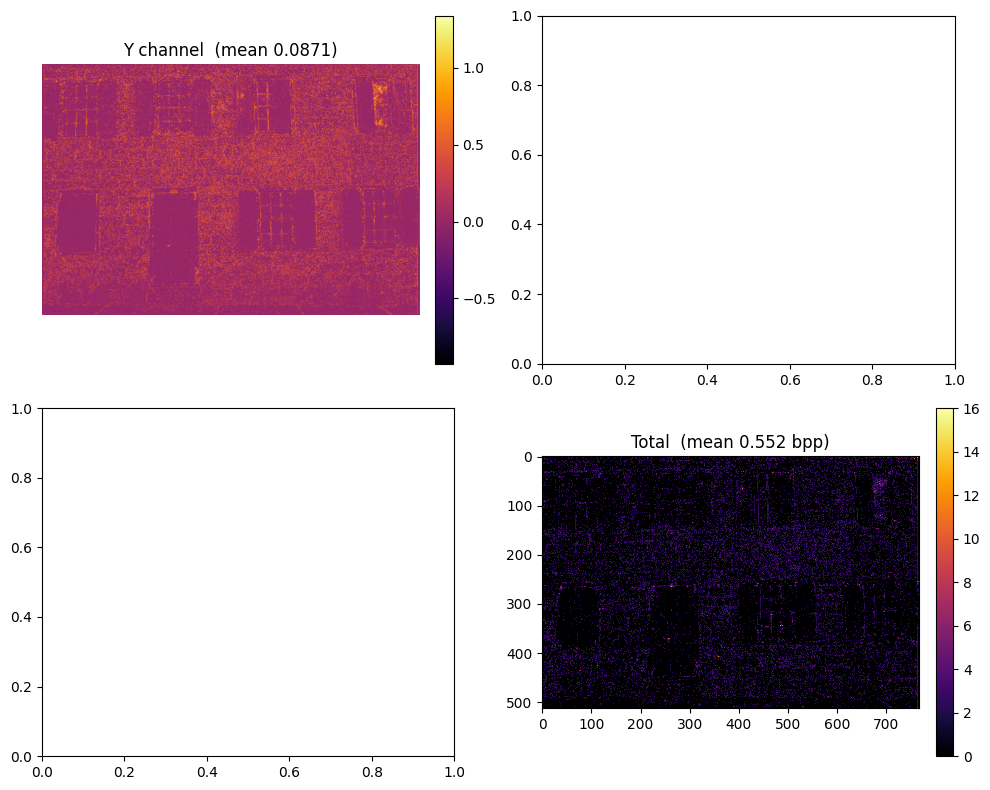

In [44]:
# plot mu, scale and the weakcolorar rates
img_rate_modified = weak_colorar_rate(mu, scale, im_tensor, colorspace_bitdepths)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

im = axes[0].imshow(mu[0].detach().cpu()[0], cmap="inferno", vmin=mu.detach().cpu()[0].min().item(), vmax=mu.detach().cpu()[0].max().item())
axes[0].set_title(f"{channel_names[0]} channel  (mean {mu[0].detach().cpu()[0].mean():.4f})")
axes[0].axis("off")
fig.colorbar(im, ax=axes[0], fraction=0.046, pad=0.04)

im = axes[3].imshow(total_rate, cmap="inferno", vmin=0, vmax=total_rate.max().item(), interpolation="nearest")
axes[3].set_title(f"Total  (mean {total_rate.mean():.3f} bpp)")
fig.colorbar(im, ax=axes[3], fraction=0.046, pad=0.04)
fig.tight_layout()
plt.show()